In [24]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import explained_variance_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# make sure TF does not allocate all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [3]:
data = np.load('simple_600K_disc0.99_cleaned.npz')
x_train = data['observations']
p_train = data['actions']
v_train = data['rewards']
x_train.shape, p_train.shape, v_train.shape

((594333, 11, 11, 18), (594333,), (594333,))

In [4]:
data = np.load('valid_100K_disc0.99_cleaned.npz')
x_test = data['observations']
p_test = data['actions']
v_test = data['rewards']
x_test.shape, p_test.shape, v_test.shape

((95623, 11, 11, 18), (95623,), (95623,))

In [74]:
c = x = Input(shape=(11,11,18))
c = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", padding="same")(c)
c = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", padding="same")(c)
c = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", padding="same")(c)
h = Flatten()(c)
#h = Dense(128, activation='relu')(h)
p = Dense(6, activation="softmax", name='p')(h)
#h = Dense(128, activation='relu')(h)
v = Dense(1, activation="tanh", name='v')(h)
model = Model(x, [p, v])
model.summary()
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[1, 0], metrics={'p': 'accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 11, 11, 18)   0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 11, 11, 256)  41728       input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 11, 11, 256)  590080      conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 11, 11, 256)  590080      conv2d_44[0][0]                  
__________________________________________________________________________________________________
flatten_15

In [75]:
callbacks = [
    ModelCheckpoint('conv.h5', monitor='val_p_acc', verbose=1, save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_p_acc', min_delta=0.001, patience=5, verbose=1, mode='max')
]

In [76]:
history = model.fit(x_train, [p_train, v_train], batch_size=512, epochs=10, validation_data=(x_test, [p_test, v_test]), callbacks=callbacks)

Train on 594333 samples, validate on 95623 samples
Epoch 1/10
594333/594333 [==============================] - 188s 316us/step - loss: 0.9410 - p_loss: 0.9410 - v_loss: 0.1741 - p_acc: 0.5675 - val_loss: 0.7122 - val_p_loss: 0.7122 - val_v_loss: 0.1774 - val_p_acc: 0.6569

Epoch 00001: val_p_acc improved from -inf to 0.65693, saving model to conv.h5
Epoch 2/10
594333/594333 [==============================] - 185s 312us/step - loss: 0.6879 - p_loss: 0.6879 - v_loss: 0.1767 - p_acc: 0.6606 - val_loss: 0.6690 - val_p_loss: 0.6690 - val_v_loss: 0.1769 - val_p_acc: 0.6687

Epoch 00002: val_p_acc improved from 0.65693 to 0.66874, saving model to conv.h5
Epoch 3/10
594333/594333 [==============================] - 185s 311us/step - loss: 0.6586 - p_loss: 0.6586 - v_loss: 0.1778 - p_acc: 0.6723 - val_loss: 0.6630 - val_p_loss: 0.6630 - val_v_loss: 0.1778 - val_p_acc: 0.6714

Epoch 00003: val_p_acc improved from 0.66874 to 0.67145, saving model to conv.h5
Epoch 4/10
594333/594333 [==============

Text(0.5,1,'Value MSE')

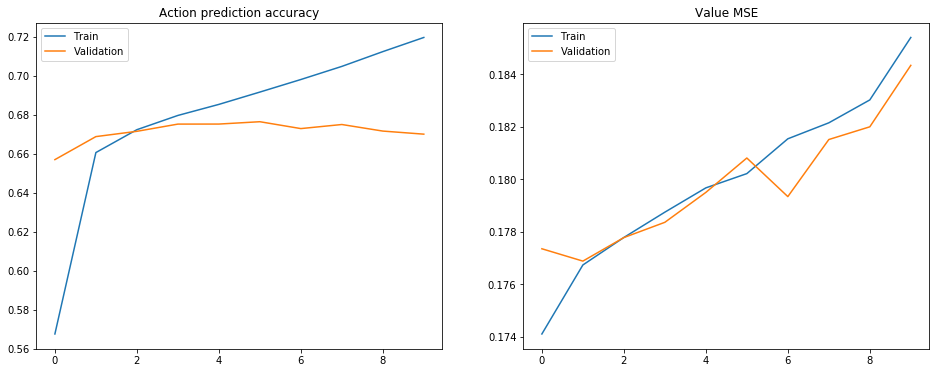

In [77]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['p_acc'])
plt.plot(history.history['val_p_acc'])
plt.legend(['Train', 'Validation'])
plt.title("Action prediction accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['v_loss'])
plt.plot(history.history['val_v_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Value MSE")

In [78]:
model = load_model('conv.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test, batch_size=2048)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.7048102662985228
Accuracy test: 0.6763749307175052
Explained variance train: -0.04325305576853089
Explained variance test: -0.04068448877452058
